In [1]:
import os
import sys
from itertools import chain, product
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from scipy.stats import spearmanr
from tqdm import tqdm, tqdm_notebook
import statsmodels.formula.api as smf

from joblib import load
from pathos.multiprocessing import ProcessingPool as Pool

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
import CPC_package as CPC
import random

%matplotlib inline

# Is is more symmetric or asymmetric to build bridges

In [2]:
#load the df here
df_grouped = load('df_random_bridge_building_triadic.joblib')

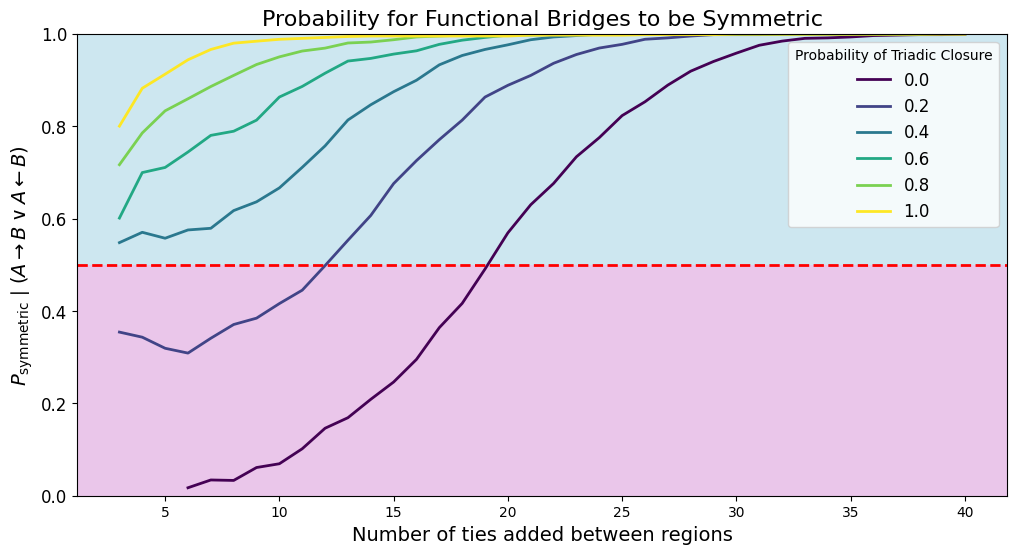

In [3]:
# Set figure size
plt.figure(figsize=(12, 6))

# Fill background colors
plt.axhspan(0, 0.5, facecolor='#DDA0DD', alpha=0.6)  # Light purple below 0.5
plt.axhspan(0.5, 1, facecolor='lightblue', alpha=0.6)  # Light blue above 0.5

# Create line plot with hue based on 'p' column
sns.lineplot(
    data=df_grouped, 
    x='counter', 
    y='portion', 
    hue='p',  # Hue based on 'p' values
    palette='viridis',  # Choose a color palette
    linewidth=2
)

# Labels and title
plt.xlabel('Number of ties added between regions', fontsize=14)
plt.ylabel(r'$P_{\text{symmetric}} \mid (A \to B \vee A \leftarrow B)$', fontsize=14)
plt.title('Probability for Functional Bridges to be Symmetric', fontsize=16)

# Improve tick readability
plt.yticks(fontsize=12)

# Add horizontal reference line
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2)

# Set y-axis limits
plt.ylim(0, 1)

# Show legend
plt.legend(title='Probability of Triadic Closure', fontsize=12)

# Save and show plot
plt.savefig('symmetric_connection_formation_triadic.png', dpi=300)
plt.show()


In [4]:
def add_prefix(node, prefix):
    return f"{prefix}_{node}"

def plot_the_graphs(graph, pos):
    plt.figure(figsize=(10, 10))
    nx.draw(graph, pos, node_size=20)
    plt.show()

def addRandomTieBetweenGraphs(graph):
    #get the nodes of graph_A and graph_B
    nodes_A = [node for node in graph.nodes() if node.startswith('A')]
    nodes_B = [node for node in graph.nodes() if node.startswith('B')]

    success = False

    while not success:
        #pick a random node from graph_A and graph_B
        node_A = random.choice(nodes_A)
        node_B = random.choice(nodes_B)

        #check if there is already a tie between the two nodes
        if not graph.has_edge(node_A, node_B):
            success = True
            #add a tie between the two nodes
            graph.add_edge(node_A, node_B)

    return graph

def getGraph():
    N, k, beta = 100, 6, 0.1
    #create a WS graph
    graph_A = nx.watts_strogatz_graph(N, k, beta)
    graph_B = nx.watts_strogatz_graph(N, k, beta)
    #relabel all graphs in graph_A by adding the prefix 'A' to the node label
    graph_A = nx.relabel_nodes(graph_A, lambda node: add_prefix(node, 'A'))
    #relabel all graphs in graph_B by adding the prefix 'B' to the node label
    graph_B = nx.relabel_nodes(graph_B, lambda node: add_prefix(node, 'B'))

    #calculate the position of the nodes in the graph_A and graph_B
    pos_A = nx.kamada_kawai_layout(graph_A)
    pos_B = nx.kamada_kawai_layout(graph_B)
    #move the nodes of graph_B to the right
    for node in pos_B:
        pos_B[node][0] += 3

    #merge the positions of graph_A and graph_B
    pos = {}
    pos.update(pos_A)
    pos.update(pos_B)

    #merge the graphs into one graph
    graph = nx.compose(graph_A, graph_B)
    return graph, pos

def addTriadicClosureBetweenGraphs(graph):
    #get the nodes of graph_A and graph_B
    nodes_A = [node for node in graph.nodes() if node.startswith('A')]
    nodes_B = [node for node in graph.nodes() if node.startswith('B')]

    success = False

    while not success:
        #pick a random node from graph_A and graph_B
        node_A = random.choice(nodes_A)
        node_B = random.choice(nodes_B)

        #check if there is already a tie between the two nodes
        if graph.has_edge(node_A, node_B):
            if random.random() < 0.5:
                #make closure from A to neib of B
                #pick a random neighbor of node_B
                neighbor_B = random.choice(list(graph.neighbors(node_B)))
                #check if there is already a tie between node_A and neighbor_B
                if not graph.has_edge(node_A, neighbor_B) and node_A != neighbor_B:
                    done = True
                    #add a tie between the two nodes
                    graph.add_edge(node_A, neighbor_B)
                    success = True
            else:
                #make closure from B to neib of A
                #pick a random neighbor of node_A
                neighbor_A = random.choice(list(graph.neighbors(node_A)))
                #check if there is already a tie between node_B and neighbor_A
                if not graph.has_edge(node_B, neighbor_A) and node_B != neighbor_A:
                    #add a tie between the two nodes
                    graph.add_edge(node_B, neighbor_A)
                    success = True
            #add a tie between the two nodes
            graph.add_edge(node_A, node_B)

    return graph

In [5]:
def getGraph():
    N, k, beta = 50, 6, 0.1
    #create a WS graph
    graph_A = nx.watts_strogatz_graph(N, k, beta)
    graph_B = nx.watts_strogatz_graph(N, k, beta)
    #relabel all graphs in graph_A by adding the prefix 'A' to the node label
    graph_A = nx.relabel_nodes(graph_A, lambda node: add_prefix(node, 'A'))
    #relabel all graphs in graph_B by adding the prefix 'B' to the node label
    graph_B = nx.relabel_nodes(graph_B, lambda node: add_prefix(node, 'B'))

    #calculate the position of the nodes in the graph_A and graph_B
    pos_A = nx.spring_layout(graph_A, k=0.01, scale=1)
    pos_B = nx.spring_layout(graph_B, k=0.01, scale=1)
    #move the nodes of graph_B to the right
    for node in pos_B:
        pos_B[node][0] += 3

    #merge the positions of graph_A and graph_B
    pos = {}
    pos.update(pos_A)
    pos.update(pos_B)

    #merge the graphs into one graph
    graph = nx.compose(graph_A, graph_B)
    return graph, pos

def plot_the_graphs(graph, pos, filename = None):
    plt.figure(figsize=(10, 10), facecolor='none')  # Set figure background to transparent
    ax = plt.gca()  # Get the current axes
    ax.set_facecolor('none')  # Set axes background to transparent
    ax.set_xticks([])  # Remove x-ticks
    ax.set_yticks([])  # Remove y-ticks
    ax.set_frame_on(False)  # Remove the frame

    nx.draw(graph, pos, node_size=100)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, dpi=300, transparent=True)

In [6]:
G, pos = getGraph()
G = addRandomTieBetweenGraphs(G)

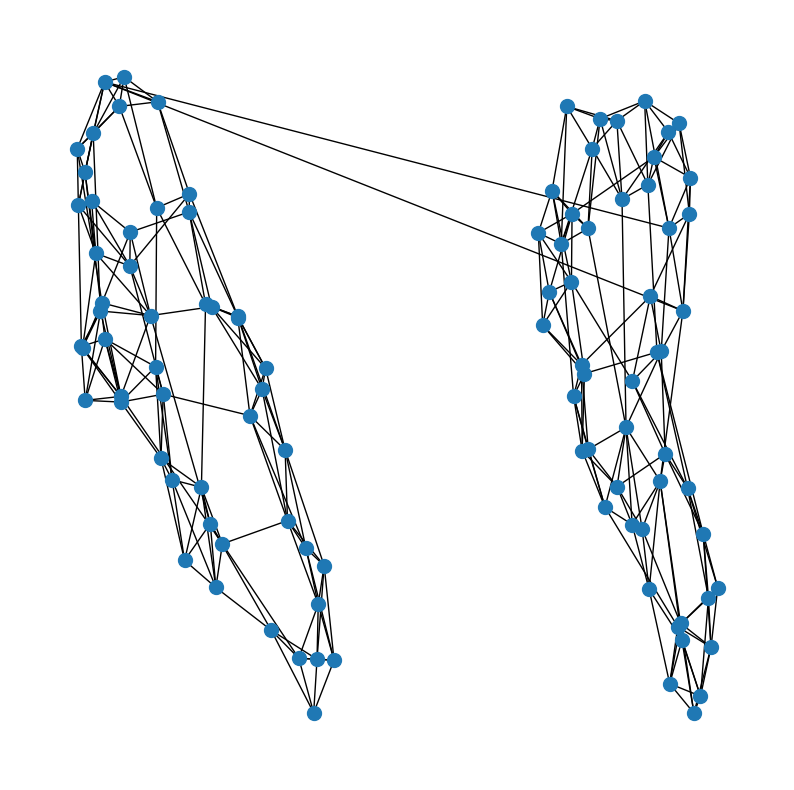

In [7]:
G = addTriadicClosureBetweenGraphs(G)
plot_the_graphs(G, pos, filename='graph1.png')

In [8]:
G, pos = getGraph()

In [9]:
G = addRandomTieBetweenGraphs(G)
for i in range(2):
    G = addTriadicClosureBetweenGraphs(G)

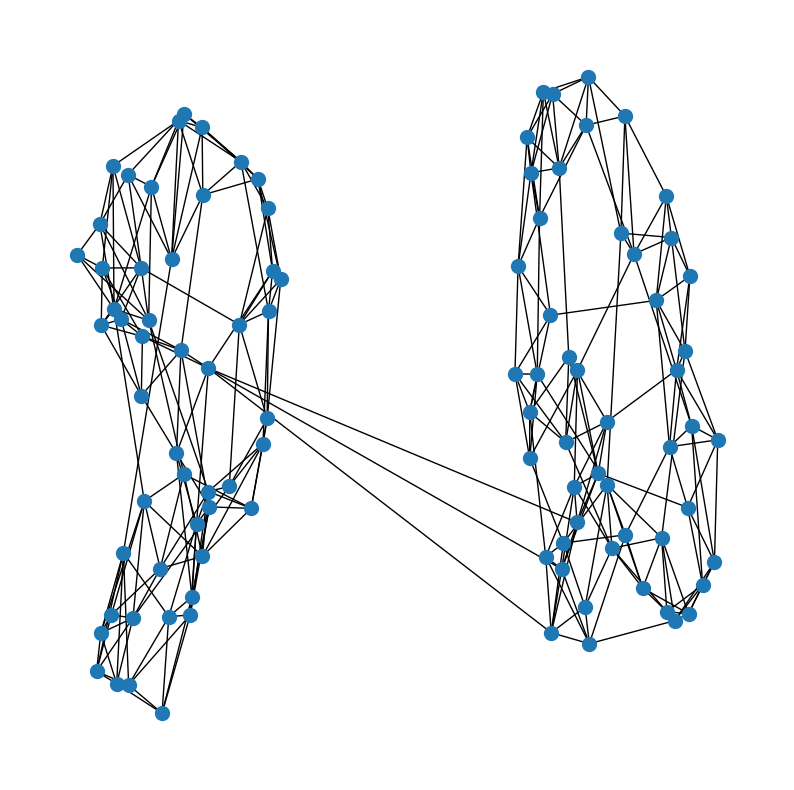

In [10]:
plot_the_graphs(G, pos, filename='graph1.png')

In [11]:
for i in range(7):
    G = addTriadicClosureBetweenGraphs(G)

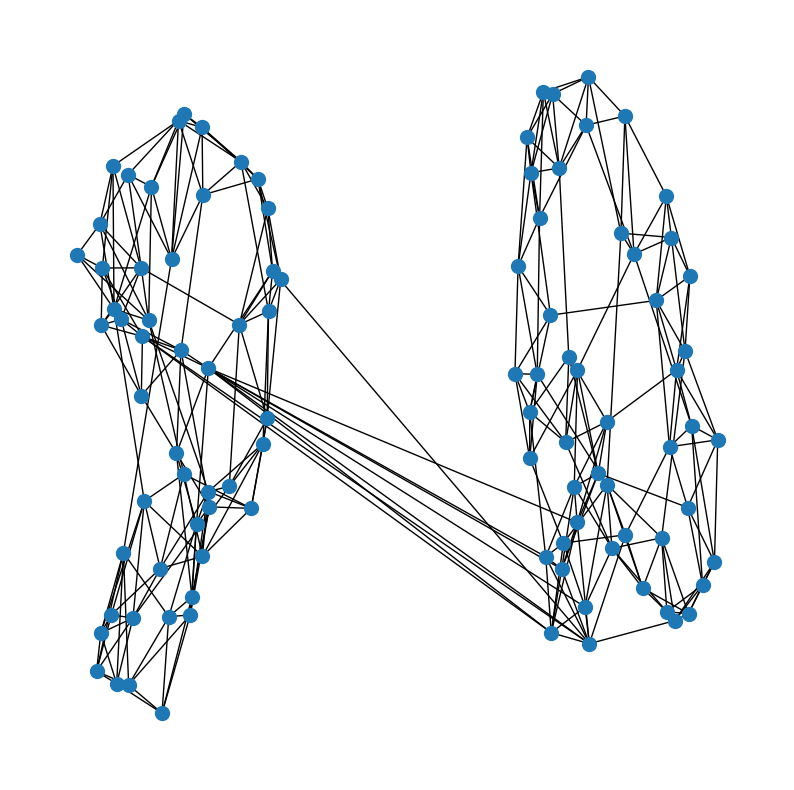

In [12]:
plot_the_graphs(G, pos, filename='graph2.png')

In [13]:
for i in range(10):
    G = addTriadicClosureBetweenGraphs(G)

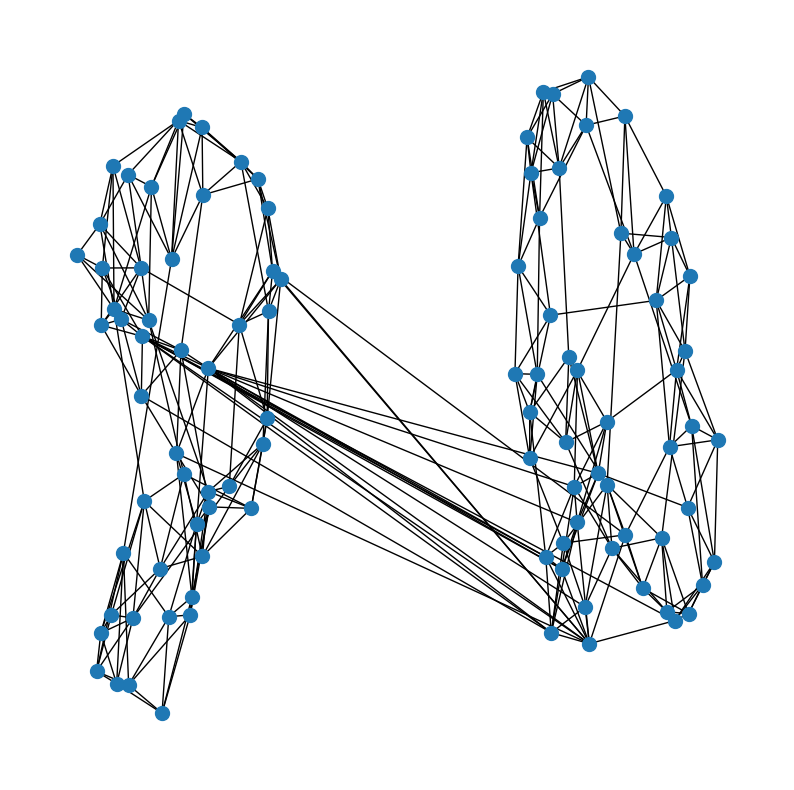

In [14]:
plot_the_graphs(G, pos, filename='graph3.png')